In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
import datetime

from scipy.stats import norm
import scipy.optimize as opt
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Load binance api secrete keys
client = Client("RnhiRv77dFVMTithm6xxyoQ1vsKLz0GHIctFGG8symPetHqw2auwJw4JuZzWHtkj", "ZYmpBejaDkYMo9Umw0yYhmMmeaO2kZRv1CQRggaUBSLOSWwCmGZFtAGn13gmrAhV")

In [2]:
# Load crypto historical data  
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Jan, 2021", "1 Jan, 2023")
df = pd.DataFrame(klines, columns = ['ot', 'open', 'high', 'low', 'close', 'volume', 'ct', 'qsv', 'no_trade', 'tbav', 'tbqv', 'ign'])

df.head(2).append(df.tail(2))

,ot,open,high,low,close,volume,ct,qsv,no_trade,tbav,tbqv,ign
0,1609459200000,28923.63000000,29031.34000000,28690.17000000,28995.13000000,2311.81144500,1609462799999,66768830.34010008,58389,1215.35923800,35103542.78288276,0
1,1609462800000,28995.13000000,29470.00000000,28960.35000000,29409.99000000,5403.06847100,1609466399999,158357816.81805722,103896,3160.04170100,92613991.93555293,0
17506,1672527600000,16520.28000000,16551.24000000,16487.74000000,16542.40000000,4973.43307000,1672531199999,82171827.98082210,152632,2451.02335000,40496375.73490570,0
17507,1672531200000,16541.77000000,16545.70000000,16508.39000000,16529.67000000,4364.83570000,1672534799999,72146293.58672290,149854,2179.94772000,36032352.87035720,0


In [3]:
# Perform dataframe with selected data and datetime
perf = df.loc[:, ['ct', 'close', 'volume']].set_index(['ct'])
perf.index = pd.to_datetime(perf.index, unit='ms')
# Transform pandas object value to numeric 
perf["close"] = pd.to_numeric(perf["close"])
perf["volume"] = pd.to_numeric(perf["volume"])

perf

,close,volume
ct,,
2021-01-01 00:59:59.999,28995.13000000,2311.81144500
2021-01-01 01:59:59.999,29409.99000000,5403.06847100
2021-01-01 02:59:59.999,29194.65000000,2384.23156000
2021-01-01 03:59:59.999,29278.40000000,1461.34507700
2021-01-01 04:59:59.999,29220.31000000,2038.04680300
...,...,...
2022-12-31 20:59:59.999,16568.60000000,2622.14355000
2022-12-31 21:59:59.999,16548.28000000,3618.77389000
2022-12-31 22:59:59.999,16520.81000000,6695.13625000


In [5]:
# Resample to hour data
h_df = pd.DataFrame(perf.loc[:, ['close', 'volume']]).resample('H', closed='left', label='left').mean().copy()
h_df['log_price'] = np.log(h_df['close'].astype(float))
h_df['return'] = h_df['close'].astype(float).pct_change().dropna()
h_df['log_return'] = h_df['log_price'] - h_df['log_price'].shift(1)
h_df['squared_log_return'] = np.power(h_df['log_return'], 2)

# Scale up 10x
h_df['return_10x'] = np.multiply(h_df['return'], 10)
h_df['log_return_10x'] = np.multiply(h_df['log_return'], 10)

h_df.head()

,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x
ct,,,,,,,,
2021-01-01 00:00:00,28995.13,2311.811445,10.274883,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,29409.99,5403.068471,10.289090,0.014308,0.014207,0.000202,0.143079,0.142065
2021-01-01 02:00:00,29194.65,2384.231560,10.281741,-0.007322,-0.007349,0.000054,-0.073220,-0.073489
2021-01-01 03:00:00,29278.40,1461.345077,10.284605,0.002869,0.002865,0.000008,0.028687,0.028646
2021-01-01 04:00:00,29220.31,2038.046803,10.282619,-0.001984,-0.001986,0.000004,-0.019841,-0.019860


In [6]:
# Resample to 5-hours data
five_h_df = pd.DataFrame(h_df.loc[:, ['close', 'volume']], index=h_df.index).resample('5H', closed='left', label='left').mean().copy()
five_h_df['log_price'] = np.log(five_h_df['close'].astype(float))
five_h_df['log_return'] = five_h_df['log_price'] - five_h_df['log_price'].shift(1)
five_h_df['squared_log_return'] = np.power(five_h_df['log_return'], 2)

five_h_df.head()

,close,volume,log_price,log_return,squared_log_return
ct,,,,,
2021-01-01 00:00:00,29219.696,2719.700671,10.282598,NaN,NaN
2021-01-01 05:00:00,29131.282,1860.217046,10.279568,-0.003030,0.000009
2021-01-01 10:00:00,29312.686,2653.873836,10.285776,0.006208,0.000039
2021-01-01 15:00:00,29134.124,2526.005848,10.279665,-0.006110,0.000037
2021-01-01 20:00:00,29230.568,1604.419477,10.282970,0.003305,0.000011


In [9]:
# Resample to daily data
d_df = pd.DataFrame(h_df.loc[:, ['close', 'volume']], index=h_df.index).resample('D', closed='left', label='left').mean().copy()
d_df['log_price'] = np.log(d_df['close'].astype(float))
d_df['return'] = d_df['close'].astype(float).pct_change().dropna()
d_df['log_return'] = d_df['log_price'] - d_df['log_price'].shift(1)
d_df['squared_log_return'] = np.power(d_df['log_return'], 2)

# Scale up 10x
d_df['return_10x'] = np.multiply(d_df['return'], 10)
d_df['log_return_10x'] = np.multiply(d_df['log_return'], 10)

d_df['realized_variance_1h'] = pd.Series(h_df.loc[:, 'squared_log_return'], index=h_df.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_1h'] = np.sqrt(d_df['realized_variance_1h'])

d_df['realized_variance_5h'] = pd.Series(five_h_df.loc[:, 'squared_log_return'], index=h_df.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_5h'] = np.sqrt(d_df['realized_variance_5h'])

d_df.head()


,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x,realized_variance_1h,realized_volatility_1h,realized_variance_5h,realized_volatility_5h
ct,,,,,,,,,,,,
2021-01-01,29206.012500,2257.621875,10.282130,NaN,NaN,NaN,NaN,NaN,0.000588,0.024258,0.000096,0.009797
2021-01-02,30737.667500,5416.411390,10.333244,0.052443,0.051114,0.002613,0.524431,0.511143,0.009689,0.098435,0.003942,0.062789
2021-01-03,33433.440000,5039.898615,10.417312,0.087703,0.084068,0.007067,0.877026,0.840677,0.003322,0.057640,0.002470,0.049700
2021-01-04,31898.536667,5870.828570,10.370315,-0.045909,-0.046996,0.002209,-0.459092,-0.469965,0.005619,0.074961,0.004503,0.067101
2021-01-05,32225.662083,4835.416543,10.380518,0.010255,0.010203,0.000104,0.102552,0.102030,0.005084,0.071299,0.004644,0.068147


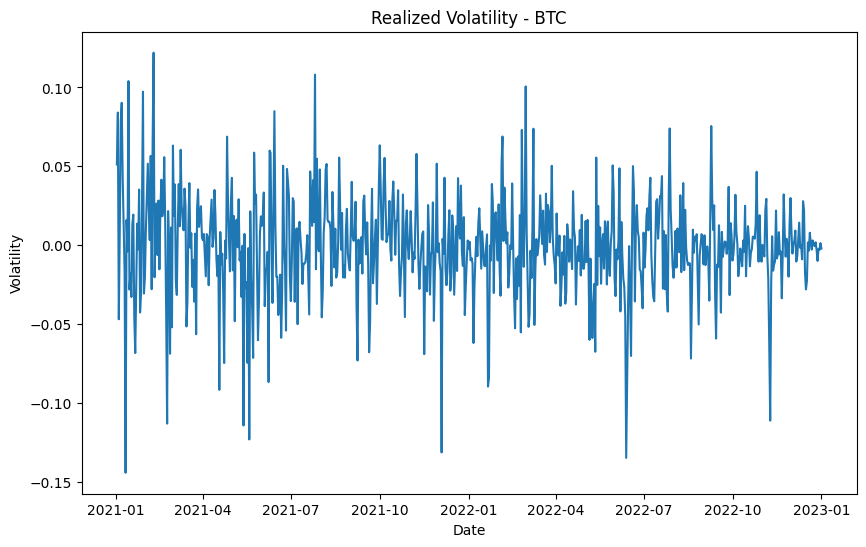

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(d_df[1:].index, d_df['log_return'][1:])
plt.title('Realized Volatility - BTC')
plt.ylabel('Volatility')
plt.xlabel('Date')
#plt.savefig('images_btc_vola/realized_btc_vol.png')
plt.show()

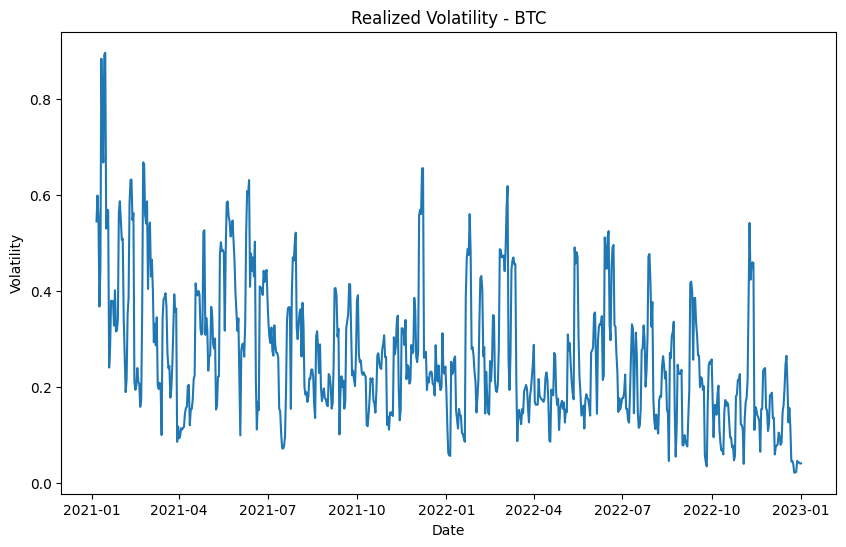

In [11]:
# Log reutn 10x
plt.figure(figsize=(10, 6))
plt.plot(d_df[1:].index, d_df['log_return_10x'][1:].rolling(5).std())
plt.title('Realized Volatility - BTC')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

### testing all garch models

In [13]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [17]:
# Default data
ret = d_df['log_return_10x'][1:] # 10x will Decrease Convergence Effect
retv = ret.values

realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['ct']

In [36]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)


realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)
y = realized_vol

In [37]:
""" Para plotear los resultados utilizaremos la siguiente función """
def boxplots_algorithms(results, names, metric):
        
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.title(metric)
    plt.show()

In [ ]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models

def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [ ]:
p_rng = range(0,30)
q_rng = range(0,40)
df['dif_pct_change'] = df['pct_change'].diff()
top_models = gridsearch(df['dif_pct_change'], p_rng, q_rng)
print(top_models)

In [ ]:
garch = arch_model(df['pct_change'], vol='GARCH', p=17, q=25, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')
fgarch.summary()

In [38]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)



for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        cv_technique = ts_cv.split(X,y)
        cv_results = cross_val_score(model,                 # Pipeline
                                     X[selected_features],  # Feature matrix
                                     y,                     # Target vector
                                     cv=cv_technique,       # Cross-validation technique
                                     scoring=scoring,       # Scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric)

NameError: name 'metrics' is not defined

In [46]:
from sklearn.model_selection import TimeSeriesSplit
ts_cv = TimeSeriesSplit(
     n_splits=5
)

cv_technique = list(ts_cv.split(X,y))

In [48]:
len(cv_technique)

5

In [ ]:
X_train = X.iloc[:-n].values
X_test = X.iloc[-n:]

y_train = realized_vol.iloc[1:-(n-1)].values.reshape(-1,)
y_test = realized_vol.iloc[-n:].values.reshape(-1,)

In [20]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [21]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

list_svr = [svr_poly, svr_lin, svr_rbf]

In [ ]:
""" Realizaremos un análisis de los siguientes modelos con las siguentes features """

seed = 42

models = []
models.append(('LR', LinearRegression()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor(random_state=seed, n_jobs = -1)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('XGB', xgb(random_state=seed)))
models.append(('LGBM', LGBMRegressor(random_state=seed)))
models.append(('CATBOOST', CatBoostRegressor(random_state=seed)))

metrics = []
metrics.append(('RMSE','neg_root_mean_squared_error'))

In [ ]:
for metric, scoring in metrics:
    results = []
    names = []
    for name, model in models:

        cv_technique = CustomTimeSeriesSplit('ID', X=X[selected_features], n_splits=2)
        cv_results = cross_val_score(model,                 # Pipeline
                                     X[selected_features],  # Feature matrix
                                     y,                     # Target vector
                                     cv=cv_technique,       # Cross-validation technique
                                     scoring=scoring,       # Scoring
                                     n_jobs = -1) 

        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

        results.append(cv_results)
        names.append(name)

    boxplots_algorithms(results, names, metric)